In [1]:
import scipy.spatial
import random
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import matplotlib.colors as mcolors
import networkx as nx
from math import sqrt, pi, isclose

from copy import copy



In [2]:
def ccw(A,B,C):
    Ax,Ay=A
    Bx,By=B
    Cx,Cy=C
    return (Cy-Ay) * (Bx-Ax) > (By-Ay) * (Cx-Ax)

# Return true if line segments AB and CD intersect
def intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

def edge_intersect(E,F):
    A,B = E
    C,D = F
    return intersect(A,B,C,D)

def line_intersection(E, F):
    xdiff = (E[0][0] - E[1][0], F[0][0] - F[1][0])
    ydiff = (E[0][1] - E[1][1], F[0][1] - F[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*E), det(*F))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

def sign(v):
    if isclose(v,0):
        return 0
    elif v>0:
        return 1
    elif v<0:
        return -1

def point_is_LR_of_line(p, line):
    x,y=p
    A,B = line
    Ax,Ay=A
    Bx,By=B
    position = sign((Bx-Ax)*(y-Ay) - (By-Ay) * (x-Ax))
    if position is None:
        print("no side", p)
        return 0
    return position

def centroid_of_shape(S):
    length=len(S)
    if length > 0:
        mean_x=sum([x for x,y in S])/length
        mean_y=sum([y for x,y in S])/length
        if mean_x is None or mean_y is None:
            print(S, "no centroid")
        return [mean_x, mean_y]
    else:
        return None


def split_shape(V,i,line):
    # Split the voronoi region located at i by
    # cutting it with a line defined by two points
    region_point_indices = V.regions[V.point_region[i]]
    region_vertices = [V.vertices[v] for v in V.regions[V.point_region[i]]]
    s_boundaries=[(region_vertices[i-1], region_vertices[i]) for i,s in enumerate(region_vertices)]
    shape_lines_and_cuts = [(e,edge_intersect(l, line), l, line_intersection(l, line) if edge_intersect(l, line) else None) for e,l in enumerate(s_boundaries)]
    return shape_lines_and_cuts

In [3]:
def genuniquecoordinates(m,n):
    seen = set()
    while True:
        x,y = random.randint(0,m), random.randint(0,n)
        if (x,y) not in seen:
            seen.add((x,y))
            yield(x,y)        

def gen_voronoi_points(space, number, seed=None):
    
    boundary_points=[]
    c=0
    for x in np.linspace(0, space[0],3):
        c=-space[1]
        boundary_points.append(np.array([x,c]))
    c=0
    for x in np.linspace(0, space[0],3):
        c=space[1]*2
        boundary_points.append(np.array([x,c]))
    x=0
    for c in np.linspace(0, space[1],3):
        x=-space[0]
        boundary_points.append(np.array([x,c]))
    x=0
    for c in np.linspace(0, space[1],3):
        x=space[0]*2
        boundary_points.append(np.array([x,c]))

    boundary_points=np.array(boundary_points).T

    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
    gencoords=genuniquecoordinates(*space)
    rand_point_coords = np.array([next(gencoords) for i in range(0,number)]).T
#    unique_rand_point_coords = np.array(list(set([tuple(c) for c in rand_point_coords.T]))).T
    unique_rand_point_coords = rand_point_coords
    point_coords= np.hstack([unique_rand_point_coords, 
                             boundary_points])
    
    vor = scipy.spatial.Voronoi(point_coords.T, furthest_site=False)
    delaunay = scipy.spatial.Delaunay(point_coords.T, furthest_site=False)
    

    return len(unique_rand_point_coords.T), vor, delaunay

In [23]:
space_dims = (400,400)

number_of_points = 25

In [24]:
number_of_points,V,D = gen_voronoi_points(space_dims, number_of_points, seed=12345) 
number_of_points

25

In [25]:
def hexfill(r):
    return 3 * r * (r+1) + 1

def get_d(N, area):
    # Using hexpacking as optimal way of squeezing N items into a circular area:
    # https://oeis.org/A003215
    # Reversing to find approximate expected distance for N items in a given area
    # Joining points closer than this expected value results in optimal balance between
    # nothing joining and everything joining
    ratio = (1/6) * (sqrt(12 * N - 3) - 3)
    R = sqrt(area/pi)
    d = (R/ratio)
    return d

In [26]:
class cell_map(object):
    def __init__(self):
        pass

    def from_voronoi(self, V, shape2d, number_of_points):
        self.original_number_of_points = number_of_points
        self.bounds = shape2d
        self.points=np.copy(V.points)[:number_of_points]
        self.vertices=np.copy(V.vertices)
        self.point_region=np.array([v for v in range(0,number_of_points)])
        self.regions=copy(V.regions)
        self.regions = [C.regions[r] for r in [r for r in V.point_region[:number_of_points]]]
        self.centroids = self.calc_centroids()

        cut_lines = [[[-self.bounds[0]*2, 0], [self.bounds[0]*2, 0]],
            [[self.bounds[0], -self.bounds[1]*2], [self.bounds[0], self.bounds[1]*2]],
            [[self.bounds[0]*2, self.bounds[1]], [-self.bounds[0]*2, self.bounds[1]]],
            [[0, self.bounds[1]*2], [0, -self.bounds[1]*2]]]
        
        for k in range(0,4):
            shape_count = len(self.regions)
            for i in range(0, shape_count):
                sc = split_shape(C,i,cut_lines[k])
                #print(sc[2])
                cut_locs = [c[0] for c in sc if c[1]]
                if len(cut_locs)>0:
                    cut_ix = len(self.vertices),len(self.vertices)+1
                    cut_vx = [c[3] for c in sc if c[1]]
                    a = C.regions[self.point_region[i]][0:cut_locs[0]] + [cut_ix[0], cut_ix[1]] + self.regions[self.point_region[i]][cut_locs[1]:]
                    b = [cut_ix[0]] + self.regions[self.point_region[i]][cut_locs[0]:cut_locs[1]] + [cut_ix[1]]
                    self.vertices=np.append(self.vertices,np.array([cut_vx[0]]), axis=0)
                    self.vertices=np.append(self.vertices,np.array([cut_vx[1]]),axis=0)
                    a_vertices = np.array([self.vertices[v] for v in a])
                    b_vertices = [self.vertices[v] for v in b]
                    a_centroid = (sum([x for x,y in a_vertices])/len(a_vertices),sum([y for x,y in a_vertices])/len(a_vertices))
                    b_centroid = (sum([x for x,y in b_vertices])/len(b_vertices),sum([y for x,y in b_vertices])/len(b_vertices))
                    if point_is_LR_of_line(a_centroid, cut_lines[k])>=0:
                        self.regions[i]=a
                        self.centroids[i]=a_centroid
                        self.regions.append(b)
                        self.centroids.append(b_centroid)
                        self.points=np.append(C.points, np.array([b_centroid]),axis=0)
                        self.point_region=np.append(C.point_region,shape_count)
                        shape_count=shape_count+1
                    else:
                        self.regions[i]=b
                        self.centroids[i]=b_centroid
                        self.regions.append(a)
                        self.centroids.append(a_centroid)
                        self.points=np.append(C.points, np.array([a_centroid]),axis=0)
                        self.point_region=np.append(C.point_region,shape_count)
                        shape_count=shape_count+1
        

        
        return self

    def calc_centroids(self):
        centroids=[]
        for i in range(0,len(self.points)):
            region_vertices = [self.vertices[v] for v in self.regions[self.point_region[i]]]
            length=len(region_vertices)
            centroid=(sum([x for x,y in region_vertices])/length,sum([y for x,y in region_vertices])/length)
            centroids.append(centroid)
        return centroids

    def calc_linkages(self, distance=None):
        
        pdist=scipy.spatial.distance.cdist(self.points[0:self.original_number_of_points], self.points[0:self.original_number_of_points])
        
        if distance is None:
            distance = get_d(len(self.points), self.bounds[0] * self.bounds[1])
        
        links=np.array(np.where((pdist>0)&(pdist<distance))).T
        dg=nx.Graph()
        for cell in range(len(self.points)):
            dg.add_node(cell)
        for f,t in links:
            if f<t:
                dg.add_edge(int(f),int(t))
        return dg

    def calc_cell_linkages(self):
        border_facets=dict()
        live_regions = C.regions
        
        for i,r in enumerate(live_regions):
            for j in range(len(r)):
                border = tuple(sorted((r[j], r[j-1])))
                                   
                if border in border_facets.keys() :
                    if not any([b==-1 for b in border]):
                        border_facets[border].append(i)
                        #print(i, border)
                else:
                    border_facets[border]=[i]
        # Create graph containing all cells connected by borders
        rg = nx.Graph()
        for k,v in border_facets.items():
            if len(v)>1:
                rg.add_edge(int(v[0]), int(v[1]))
        return rg
        

In [27]:
C=cell_map()
C.from_voronoi(V,space_dims, number_of_points)

In [28]:
#C=cell_map()
#C.from_voronoi(V, space_dims, number_of_points)

#for k in range(0,4):
#    shape_count = len(C.regions)
#    for i in range(0, shape_count):
#        sc = split_shape(C,i,cut_lines[k])
#        #print(sc[2])
#        cut_locs = [c[0] for c in sc if c[1]]
#        if len(cut_locs)>0:
#            cut_ix = len(C.vertices),len(C.vertices)+1
#            cut_vx = [c[3] for c in sc if c[1]]
#            a = C.regions[C.point_region[i]][0:cut_locs[0]] + [cut_ix[0], cut_ix[1]] + C.regions[C.point_region[i]][cut_locs[1]:]
#            b = [cut_ix[0]] + C.regions[C.point_region[i]][cut_locs[0]:cut_locs[1]] + [cut_ix[1]]
#            C.vertices=np.append(C.vertices,np.array([cut_vx[0]]), axis=0)
#            C.vertices=np.append(C.vertices,np.array([cut_vx[1]]),axis=0)
#            a_vertices = np.array([C.vertices[v] for v in a])
#            b_vertices = [C.vertices[v] for v in b]
#            a_centroid = (sum([x for x,y in a_vertices])/len(a_vertices),sum([y for x,y in a_vertices])/len(a_vertices))
#            b_centroid = (sum([x for x,y in b_vertices])/len(b_vertices),sum([y for x,y in b_vertices])/len(b_vertices))
#            if point_is_LR_of_line(a_centroid, cut_lines[k])>=0:
#                C.regions[i]=a
#                C.centroids[i]=a_centroid
#                C.regions.append(b)
#                C.centroids.append(b_centroid)
#                C.points=np.append(C.points, np.array([b_centroid]),axis=0)
#                C.point_region=np.append(C.point_region,shape_count)
#                shape_count=shape_count+1
#            else:
#                C.regions[i]=b
#                C.centroids[i]=b_centroid
#                C.regions.append(a)
#                C.centroids.append(a_centroid)
#                C.points=np.append(C.points, np.array([a_centroid]),axis=0)
#                C.point_region=np.append(C.point_region,shape_count)
#                shape_count=shape_count+1

In [29]:
C.vertices

array([[ 567.14968153, -167.14968153],
       [-168.39439655,  568.39439655],
       [-209.01985112,  300.        ],
       [-206.50740741,  100.        ],
       [ 568.3089172 , -154.3089172 ],
       [ 339.62761836, -183.73443329],
       [ 300.        , -202.31296758],
       [ 100.        , -201.16504854],
       [ 141.23581011, -197.5619195 ],
       [ 334.03900709,   79.96099291],
       [ 568.91630901,  568.91630901],
       [ 300.        ,  599.08114558],
       [  39.35483871,  304.01985112],
       [-199.82969778,  273.35516695],
       [-192.1355858 ,  221.26224483],
       [  41.16230207,  204.13946407],
       [  81.22677596,  242.82240437],
       [ 595.83411765,  100.        ],
       [ 550.27441463,  225.73294663],
       [ 580.34675615,  300.        ],
       [ -77.85631741, -130.36787365],
       [-123.57758621, -123.57758621],
       [-124.98306655, -117.21946083],
       [  54.19457708,  149.64085948],
       [ 292.00105671,   11.78513561],
       [ 297.00222222,   

(-20.0, 420.0)

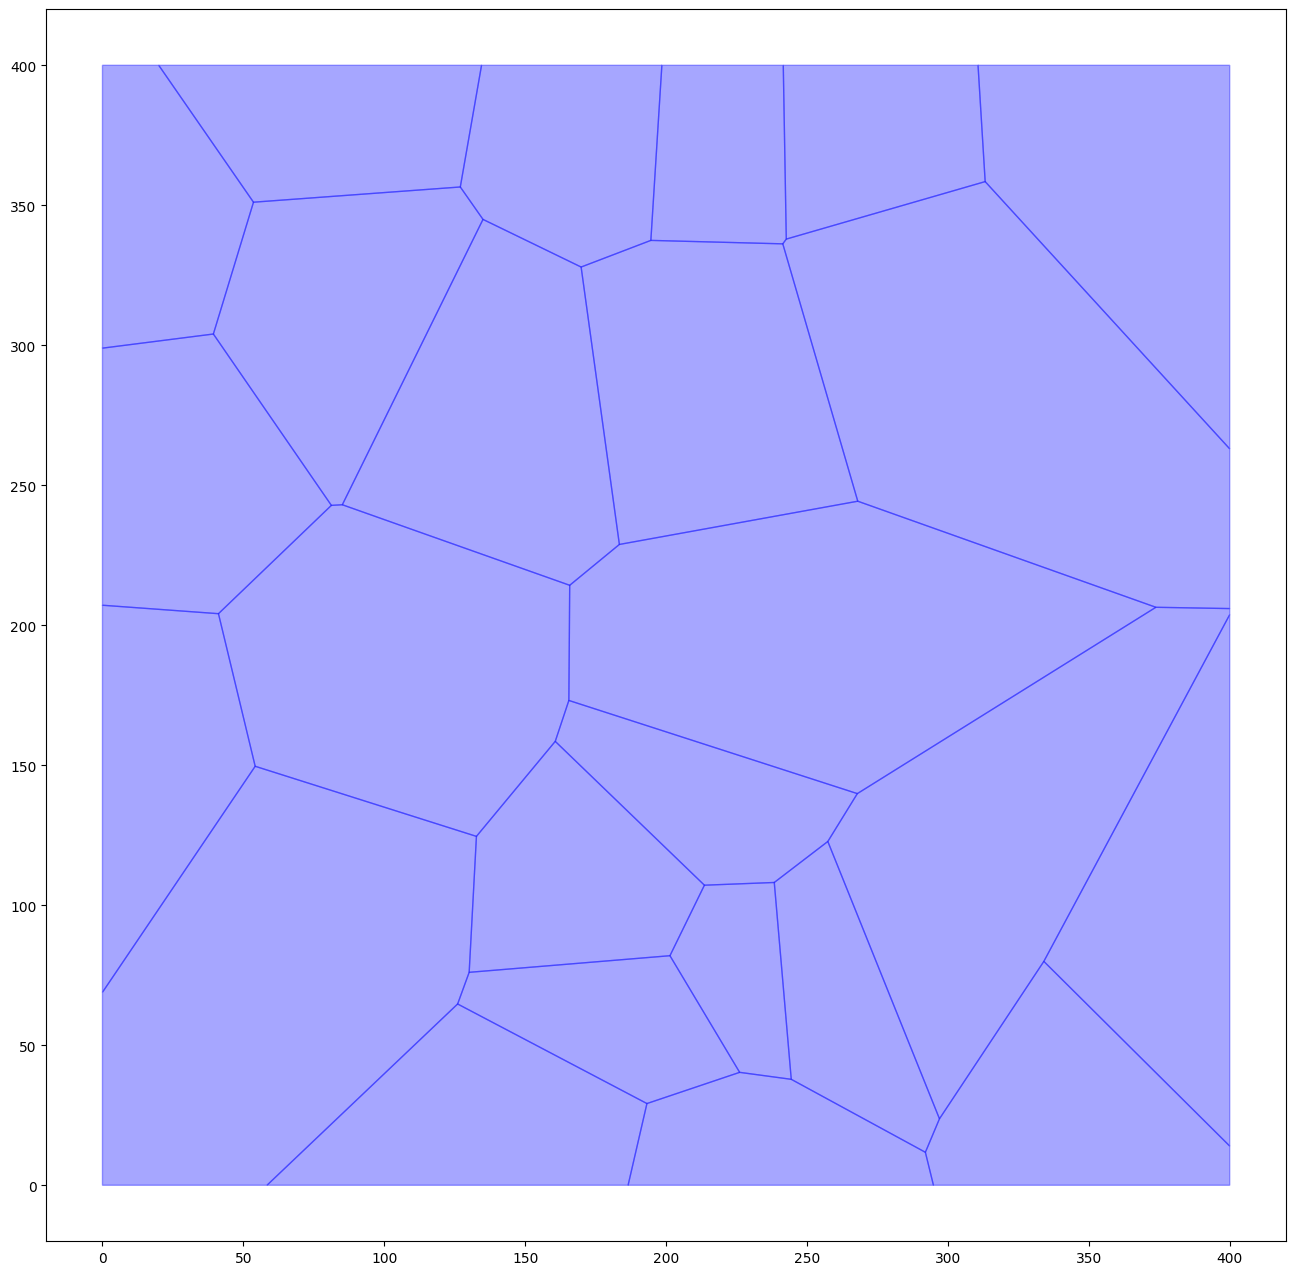

In [30]:
fig=plt.figure(figsize=(16,16))
ax = plt.gca()

for i in range(0,number_of_points):

    vi = C.regions[C.point_region[i]]
    vertices=np.array([C.vertices[v] for v in vi])
    ax.add_patch(mpatches.Polygon(np.array(vertices), edgecolor='blue', facecolor = 'blue', alpha=0.35))

#ax.scatter(*C.points[0:number_of_points].T, s=0.1)
plt.xlim(-20,420)
plt.ylim(-20,420)

In [31]:
C.calc_linkages()

In [32]:
rg=C.calc_cell_linkages()

In [33]:
rg.edges()

EdgeView([(0, 37), (0, 13), (0, 7), (13, 3), (13, 7), (13, 10), (13, 19), (7, 12), (7, 19), (7, 31), (1, 44), (1, 17), (44, 25), (17, 2), (17, 3), (17, 6), (17, 8), (17, 15), (17, 20), (17, 19), (2, 15), (2, 5), (2, 4), (2, 6), (15, 5), (15, 45), (5, 4), (5, 18), (5, 22), (4, 6), (4, 14), (4, 22), (6, 19), (6, 9), (6, 14), (3, 10), (3, 8), (3, 19), (10, 8), (10, 38), (8, 20), (8, 23), (8, 24), (19, 9), (14, 9), (14, 16), (14, 22), (22, 30), (18, 29), (9, 16), (9, 32), (12, 39), (31, 33), (20, 46), (23, 47), (24, 42), (16, 34), (11, 33), (33, 26), (33, 35), (29, 49), (21, 40), (42, 51), (27, 48), (28, 36), (35, 43), (41, 50)])

pdist=scipy.spatial.distance.cdist(C.points, C.points)

chosen_d=get_d(1000,160000)
chosen_d/2

links=np.array(np.where((pdist>0)&(pdist<chosen_d))).T
dg=nx.Graph()
for cell in range(number_of_points):
    dg.add_node(cell)
    #print(cell)
for f,t in links:
    if f<t:
        dg.add_edge(int(f),int(t))

border_facets=dict()
#live_regions = [C.regions[r] for r in C.point_region[0:number_of_points]]
live_regions = C.regions[0:number_of_points]

for i,r in enumerate(live_regions):
    for j in range(len(r)):
        border = tuple(sorted((r[j], r[j-1])))
                           
        if border in border_facets.keys() :
            if not any([b==-1 for b in border]):
                border_facets[border].append(i)
                #print(i, border)
        else:
            border_facets[border]=[i]
# Create graph containing all cells connected by borders
rg = nx.Graph()
for k,v in border_facets.items():
    if len(v)>1:
        rg.add_edge(int(v[0]), int(v[1]))


In [34]:
dg=C.calc_linkages()
rg=C.calc_cell_linkages()


all_connected = {s for r in nx.connected_components(dg) for s in r}
singletons = [set([s]) for s in set(rg.nodes()) if s not in all_connected]
region_sets = list(nx.connected_components(dg)) + singletons


region_graph=nx.Graph()
for e,r in enumerate(region_sets):
    neighbourset=set()
    for n in r:
        if n in rg.nodes():
            neighbourset.update(rg.neighbors(n))
    for f,r_two in enumerate(region_sets):
        if e!=f:
            if len(neighbourset.intersection(r_two))>0:
                region_graph.add_edge(e,f)


In [35]:
def bicolour_regions(graph):
    processed=set()
    assignments=dict()
    regions_by_size=sorted([(k,v) for k,v in graph.degree()], key=lambda x : x[1], reverse=True)
    r = regions_by_size[0][0]
    
    for r,s in regions_by_size:
        if r not in processed:
            processed.add(r)
            assignments[r]=0
            for a in graph.neighbors(r):
                if a not in processed:
                    processed.add(a)
                    assignments[a]=1
    return assignments
            

In [36]:
region_lookup = {c:e for e,v in enumerate(region_sets) for c in v}

region_colors_lookup = bicolour_regions(region_graph)

cell_region_colour_lookup = {k:region_colors_lookup.get(v) for k,v in region_lookup.items()}

clist=['forestgreen','cornflowerblue', '2','3','4','5','black']


In [37]:
shapes=[]
for i in range(0,number_of_points):

    vi = C.regions[C.point_region[i]]
    shapes.append(np.array([C.vertices[v] for v in vi]))


In [38]:
hdegree_d=dict(dg.degree)

cell_dict = dict()
for cell in rg.nodes() :
    if cell < number_of_points:
        cell_dict[cell]={}
        cell_dict[cell]["region"]=region_lookup[cell]
        cell_dict[cell]["bicolour"]=region_colors_lookup[region_lookup[cell]]
        colour_dir = 1 if region_colors_lookup[region_lookup[cell]] == 0 else -1
        cell_dict[cell]["height"]=(hdegree_d.get(cell,0)*colour_dir)-1
        cell_dict[cell]["shape"]=np.array(shapes[cell] )
        cell_dict[cell]["neighbors"]=list(rg.neighbors(cell))
        cell_dict[cell]["link_neighbors"]=list(dg.neighbors(cell))
        cell_dict[cell]['v_point']=C.points[cell]
        cell_dict[cell]['vertex_indices']=C.regions[C.point_region[cell]]
        cell_dict[cell]['vertex_pos']=[C.vertices[v] for v in C.regions[C.point_region[cell]]]


In [39]:
heights = [v['height'] for v in cell_dict.values() ]
sea_level = 0
land_heightnorm=plt.Normalize(sea_level, max(heights))
sea_heightnorm=plt.Normalize(min(heights), sea_level)


In [40]:
from matplotlib.colors import LinearSegmentedColormap

#land_colors = [(0.6, 1, 0.6), (0.3, 0.8, 0.3), (0.3, 0.3, 0.3)] 
land_colors = [(0.6, 1, 0.6), (0.2, 0.2, 0.2)] 
land_colors_cmap = LinearSegmentedColormap.from_list("land_colors", land_colors, N=16)

#sea_colors = [(0.4, 0.5, 0.9), (0.5, 0.5, 1.0), (0.6, 0.6, 1.0)] 
sea_colors = [(0.1, 0.1, 0.5), (0.6, 0.6, 1.0)] 
sea_colors_cmap = LinearSegmentedColormap.from_list("sea_colors", sea_colors, N=16)



/tmp/ipykernel_90571/1313684685.py:16: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  patch=mpatches.Polygon(data['shape'], edgecolor='black', color=cvalue, alpha=0.8)


(-5.0, 405.0)

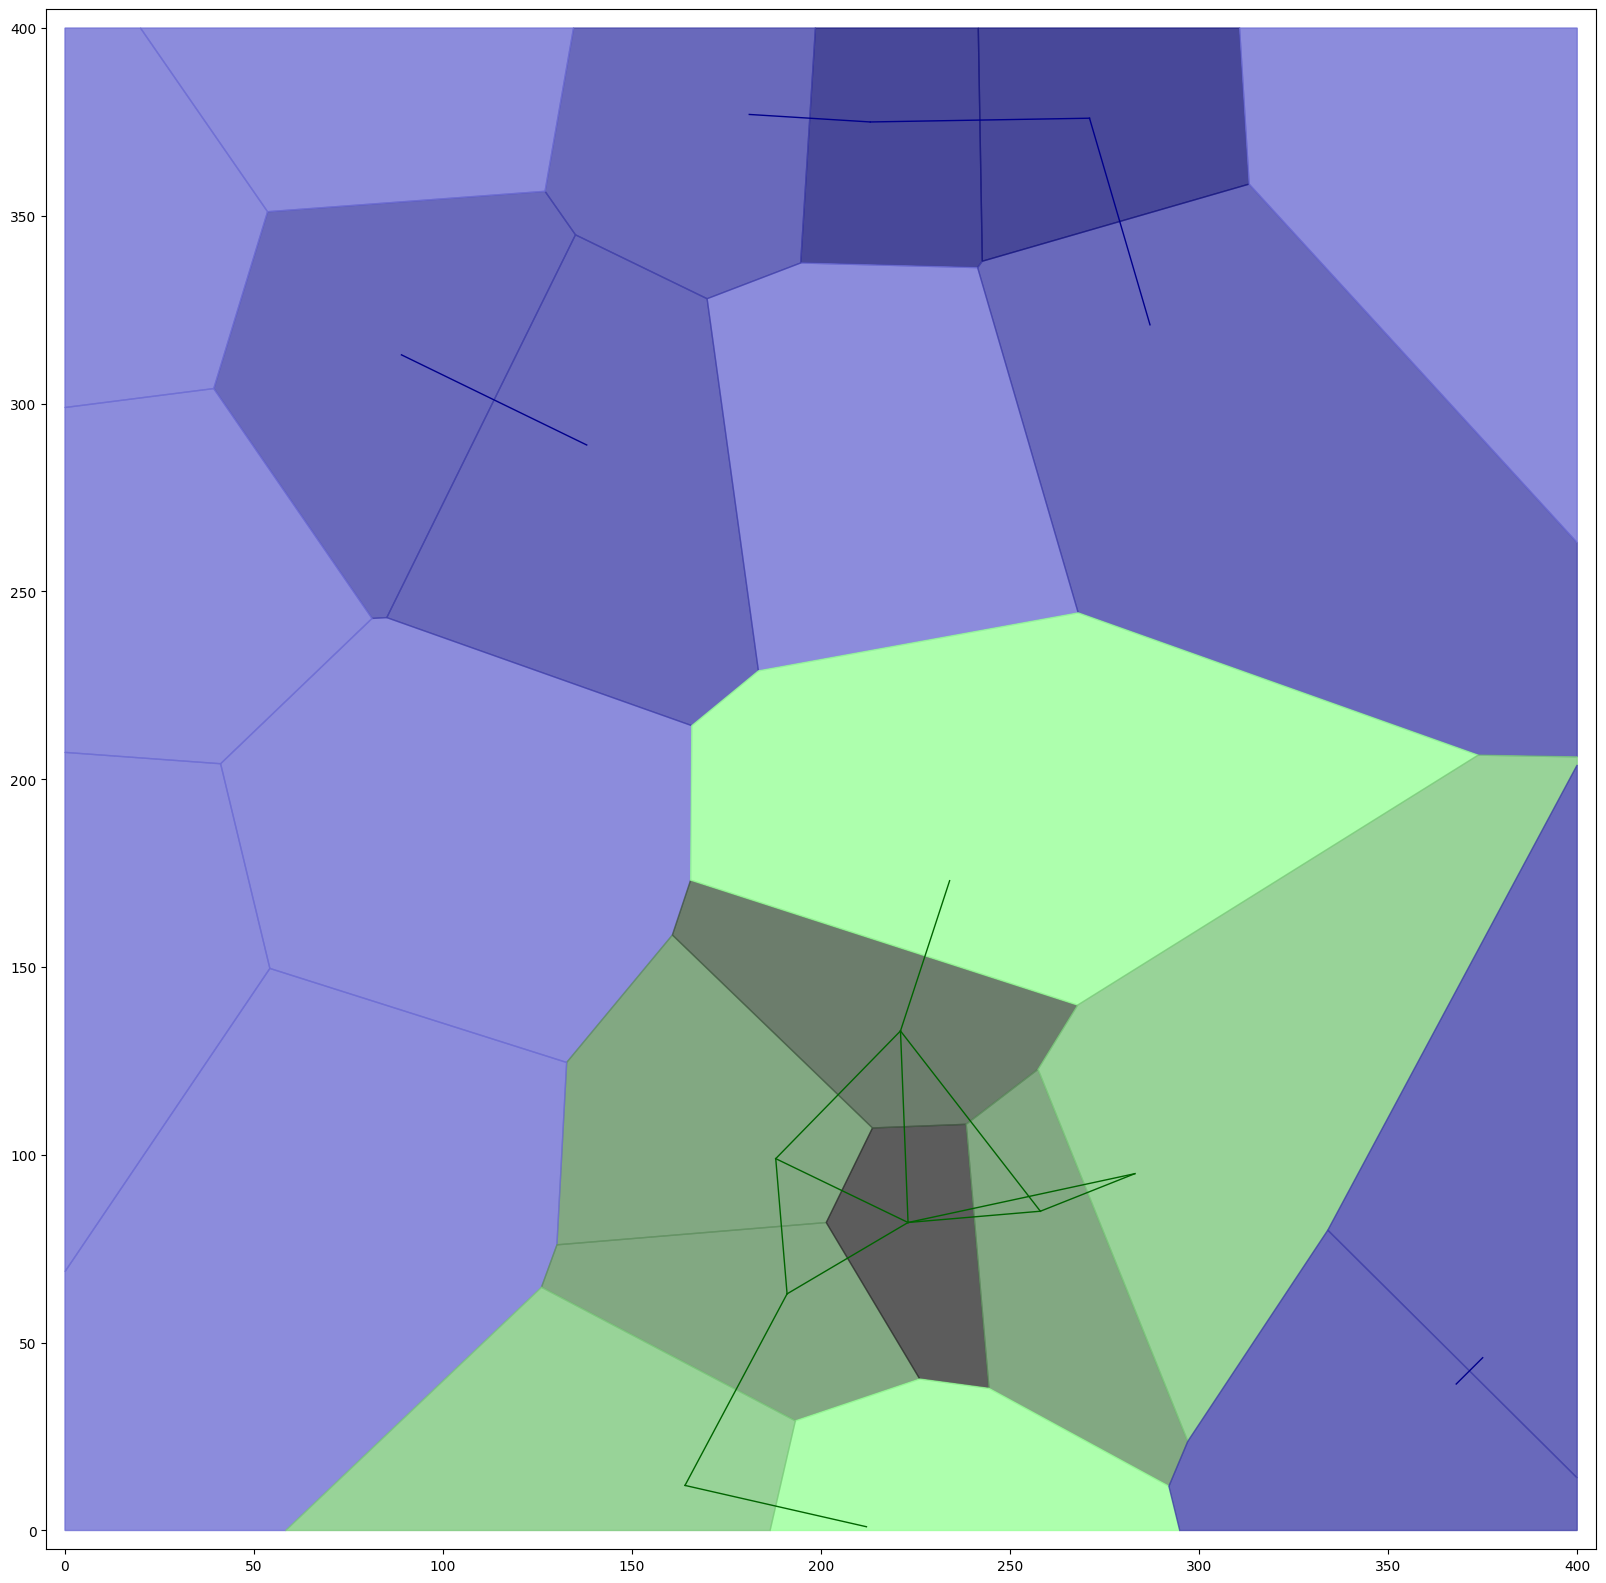

In [41]:
cmap = plt.get_cmap('gist_rainbow')
cmap = plt.get_cmap('summer')
scmap = plt.get_cmap('cool')
#cmap = plt.get_cmap('gist_ncar')
#cmap = plt.get_cmap('nipy_spectral')
#cmap = plt.get_cmap('jet')

fig=plt.figure(figsize=(20,20))
ax = plt.gca()

for cell, data in cell_dict.items():
    if data['height']>=sea_level:
        cvalue = land_colors_cmap(land_heightnorm(data['height']))
    else:
        cvalue = sea_colors_cmap(sea_heightnorm(data['height']))
    patch=mpatches.Polygon(data['shape'], edgecolor='black', color=cvalue, alpha=0.8)
    ax.add_patch(patch)


for f,t in dg.edges():
    if cell_region_colour_lookup.get(f,6)==0:
        x1y1=C.points[f][0], C.points[f][1]
        x2y2=C.points[t][0], C.points[t][1]
        plt.plot([float(x1y1[0]), float(x2y2[0])], [float(x1y1[1]), float(x2y2[1])],c='darkgreen',linewidth=1)
    elif cell_region_colour_lookup.get(f,6)==1:
        x1y1=C.points[f][0], C.points[f][1]
        x2y2=C.points[t][0], C.points[t][1]
        plt.plot([float(x1y1[0]), float(x2y2[0])], [float(x1y1[1]), float(x2y2[1])],c='darkblue',linewidth=1)

plt.xlim(-5,405)
plt.ylim(-5,405)